In [1]:
%matplotlib tk
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
path = '../images/'

# Direct Linear Transform
1. For the given image calib-object.jpg , use any 20-30 different points on different
planes and perform the Direct Linear Transform (DLT) based calibration as dis-
cussed in class. Note that you need to manually estimate the image co-ordinates of
the given world points and refer to calib-object-legend.jpg for world measure-
ments.

Assume these two scales :
(a) Scale of each chessblock = 28x28mm <br>
(b) Scale of each chessblock = 2800x2800mm <br>
Perform these three experiments, report the projection matrix and reconstruction error, for both the above mentioned scales: <br>
(a) Use original data points as input. <br>
Perform reconstruction on the original data points. (main experiment)

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

In [4]:
image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread(path+'my_phone.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

[[ 342.79702556  254.82084904]
 [ 632.69229158  256.516143  ]
 [1015.82872504  259.9067309 ]
 [ 637.77817344  815.96314761]
 [ 641.16876135  985.49254294]
 [ 630.99699763 1143.1548806 ]
 [ 432.64760508 1144.85017456]
 [ 834.43227203 1143.1548806 ]]


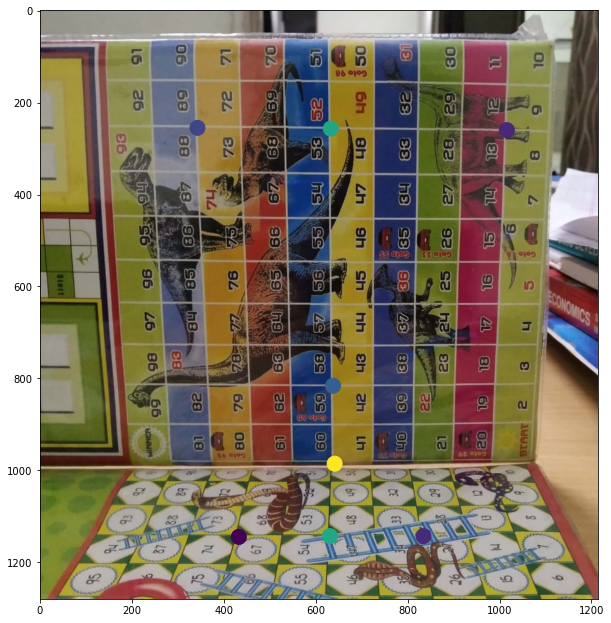

In [5]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
print(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread(path+'my_phone.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [3]:
# image_points = np.array([[ 339.40643765,  253.12555509],
#  [ 630.99699763 , 258.21143695],
#  [1014.13343109 , 258.21143695],
#  [ 634.38758553 , 812.5725597 ],
#  [ 636.08287949 , 987.18783689],
#  [ 632.69229158, 1143.1548806 ],
#  [ 425.86642927 ,1141.45958665],
#  [ 829.34639017, 1136.37370479]])

In [6]:
x = image_points
# X represents the 3D world points
X = [[-3,0,8],[0,0,8],[4,0,8],[0,0,2],[0,0,0],[0,2.5,0],[-2,2.5,0],[2,2.5,0]]

X = np.array(X)

In [7]:
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

print(x[1].shape, X[1].shape)
x,X = hom_coords(x,X)
print(x[1].shape, X[1].shape)

(2,) (3,)
(3,) (4,)


In [8]:
def DLT(x,X):
    """
    input x: the image points
    X: world points
    return Projection matrix (3x4)
    """
    i = 0
    M = np.array([-X[i][0], -X[i][1], -X[i][2], -X[i][3], 0, 0, 0, 0, x[i][0] * X[i][0], x[i][0] * X[i][1], x[i][0] * X[i][2], x[i][0] * X[i][3]])
    M = np.vstack((M, [0, 0, 0, 0, -X[i][0], -X[i][1], -X[i][2], -X[i][3], x[i][1] * X[i][0], x[i][1] * X[i][1], x[i][1] * X[i][2], x[i][1] * X[i][3]]))
      
    for i in range(len(x)):
        M = np.vstack((M, [-X[i][0], -X[i][1], -X[i][2], -X[i][3], 0, 0, 0, 0, x[i][0] * X[i][0], x[i][0] * X[i][1], x[i][0] * X[i][2], x[i][0] * X[i][3]]))
        M = np.vstack((M, [0, 0, 0, 0, -X[i][0], -X[i][1], -X[i][2], -X[i][3], x[i][1] * X[i][0], x[i][1] * X[i][1], x[i][1] * X[i][2], x[i][1] * X[i][3]]))
  
    u, d, vt = np.linalg.svd(M, full_matrices = True)
    
    P = vt[-1].reshape(3,4)
    P = P/P[2][3]
    return P
   


P = DLT(x,X)

In [9]:
#Get reprojected points
def get_points(P,X,norm = False,T_ = None):
    points = P@X.T
    if(norm==True):
        points = np.linalg.inv(T_)@points
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    points,_ = hom_coords(points,x)
    err = np.sqrt(np.mean((points - x) ** 2))
    print(err)
    return err
get_err(x,X,P)

0.5794568659780424


0.5794568659780424

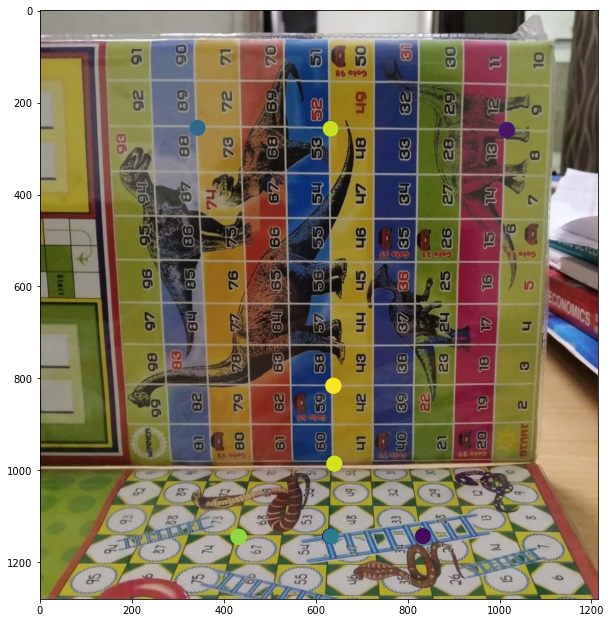

In [22]:
def reproject(P,X,norm=False,T_=None):  
    
    re_proj = get_points(P, X, norm, T_)
    re_proj = np.array(re_proj).astype('float32') 

    finalX = np.hstack((x[ : , 0], re_proj[ : , 0]))
    finalY = np.hstack((x[ : , 1], re_proj[ : , 1]))

    %matplotlib inline
    N = len(finalX)
    
    fig = plt.figure(figsize=(10,15))

    img=mpimg.imread(path+'my_phone.jpeg')
    imgplot = plt.imshow(img)

    colors = np.random.rand(N)
    area = (15 * np.ones(N))**2 
    
    plt.scatter(finalX[ : ], finalY[ : ], c = colors, s = area)
    plt.show()
    
reproject(P,X)

(b) Use normalized data points as input.
Perform reconstruction on the normalized data points (without denormalizing the projection matrix obtained) <br>


In [23]:
def find_d_2d(x):
    x_points = x[:,0]
    y_points = x[:,1]
    x_mean = np.mean(x_points)
    y_mean = np.mean(y_points)
    d_mean = np.mean(np.sqrt((x_points - x_mean)**2 + (y_points-y_mean)**2))
    return d_mean,x_mean, y_mean
 

In [24]:
def normalize_imagePoints(x):
    d_mean, x_mean, y_mean = find_d_2d(x)   
    root2 = np.sqrt(2)
    T = np.array([[root2/d_mean,0,-root2*x_mean/d_mean],
                  [0,root2/d_mean,-root2*y_mean/d_mean],
                  [0,0,1]])
    print(T.shape,x.shape)
    x_normalized = (T@x.T).T
    return x_normalized, T
    

In [25]:
x_normalized, T = normalize_imagePoints(x)
print(x_normalized.shape)

(3, 3) (8, 3)
(8, 3)


In [26]:
def find_d_3d(x):
    x_points = x[:,0]
    y_points = x[:,1]
    z_points = x[:,2]
    x_mean = np.mean(x_points)
    y_mean = np.mean(y_points)
    z_mean = np.mean(z_points)
    d_mean = np.mean(np.sqrt((x_points - x_mean)**2 + (y_points-y_mean)**2)+ (z_points-z_mean)**2)
    return d_mean,x_mean, y_mean,z_mean

In [27]:
def normalize_modelPoints(X):
    d_mean, x_mean, y_mean,z_mean = find_d_3d(X)   
    root3 = np.sqrt(3)
    U = np.array([[root3/d_mean,0,0,-root3*x_mean/d_mean],
                  [0,root3/d_mean,0,-root3*y_mean/d_mean],
                  [0,0,root3/d_mean,-root3*z_mean/d_mean],
                  [0,0,0,1]])
    print(U.shape,X.shape)
    x_normalized = (U@X.T).T
    return x_normalized, U

In [28]:
X_normalized, U = normalize_modelPoints(X)

(4, 4) (8, 4)


In [29]:
x_normalized.shape, X_normalized.shape

((8, 3), (8, 4))

In [30]:
P2 = DLT(x_normalized,X_normalized)

In [31]:
err = get_err(x_normalized,X_normalized,P2)

0.00200595928940735


In [32]:
X_normalized

array([[-0.33767757, -0.10130327,  0.5132699 ,  1.        ],
       [-0.0135071 , -0.10130327,  0.5132699 ,  1.        ],
       [ 0.41872018, -0.10130327,  0.5132699 ,  1.        ],
       [-0.0135071 , -0.10130327, -0.13507103,  1.        ],
       [-0.0135071 , -0.10130327, -0.35118467,  1.        ],
       [-0.0135071 ,  0.16883878, -0.35118467,  1.        ],
       [-0.22962075,  0.16883878, -0.35118467,  1.        ],
       [ 0.20260654,  0.16883878, -0.35118467,  1.        ]])

In [33]:
P2

array([[ 3.06492928e+00, -8.19248908e-02, -2.97676372e-02,
         1.77314651e-03],
       [ 4.64000826e-03,  1.50936776e+00, -2.99340702e+00,
        -9.32160683e-03],
       [ 1.01760844e-02, -5.18488419e-01, -1.13948334e-01,
         1.00000000e+00]])

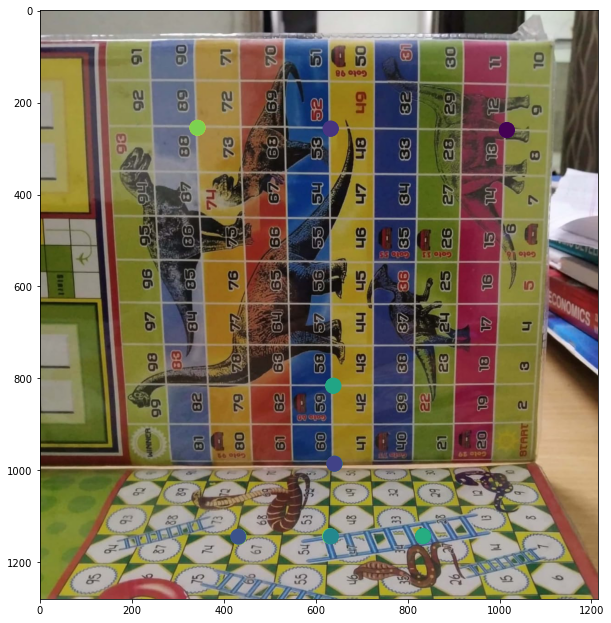

In [34]:
reproject(P2,X_normalized,norm=True, T_=T)

(c) Use normalized data points as input. <br>
Perform reconstruction on the original data points (with the denormalized projection matrix).
Do the results vary between the above experiments? If yes, report how and why are the variations observed.  <br>

In [35]:
T_inv = np.linalg.inv(T)
P_denormalized = T_inv @ P2 @ U

In [36]:
print(P_denormalized)

[[ 9.63598572e+01 -3.87520155e+01 -8.88363645e+00  6.99711682e+02]
 [ 9.70031067e-01  5.05724881e+00 -1.02658036e+02  1.07656645e+03]
 [ 1.09959533e-03 -5.60262104e-02 -1.23128948e-02  1.09240403e+00]]


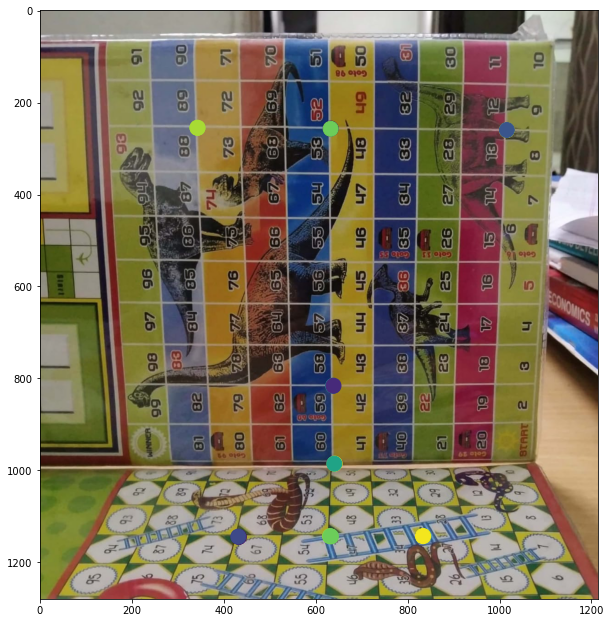

In [37]:
reproject(P_denormalized,X)

 Decompose the projection matrix obtained for the main experiment above and report: <br>
(a) camera matrix (K) <br>
(b) rotation matrix (R) <br>
(c) projection center (C) <br>
Notice that upon QR decomposition to obtain K and R, the obtained K matrix might have positive diagonal elements. This indicates a positive camera constant, while we usually assume it to be negative in theory as it becomes easier to handle
signs. To fix this we use the following method: <br>
K = KR(z, π) and R = R(z, π)R <br>
Be sure to fix the matrices using this method. Show how the decomposition still holds true with these transformed matrices.

In [38]:
def get_KRX0(P):
    #P = [KR|-KRX0] = [H|h]
    H = P[0:3, 0:3]   
    h = -P[:,-1]  
    X0 = np.linalg.inv(H)@h 
    #QR decomposition
    Rinv, Kinv = np.linalg.qr(np.linalg.inv(H))
    R = Rinv.T
    K = np.linalg.inv(Kinv)
    return R, K , X0

R, K, X0 = get_KRX0(P)
K = K/K[2][2] #Normalising to get 1.
print("Camera Intrinsics Matrix K \n",K)
print("\n Rotation Matrix R \n", R)
print("\n Projection Canter X0 \n",X0)

#this gives us positive camera constant, now to get negative camera constant
Rz_pi = np.array([[-1,0,0],[0,-1,0],[0,0,1]])
K_new = K@Rz_pi
R_new = Rz_pi@R
print('\n \nfixed matrices')
print("Camera Intrinsics Matrix K \n",K_new)
print("\n Rotation Matrix R \n", R_new)

Camera Intrinsics Matrix K 
 [[1.65788270e+03 1.66418680e+01 7.24419968e+02]
 [0.00000000e+00 1.75830092e+03 3.01915445e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 Rotation Matrix R 
 [[-0.99979853 -0.01726157 -0.01024375]
 [-0.00629253 -0.21507588  0.97657707]
 [-0.01906044  0.97644478  0.21492393]]

 Projection Canter X0 
 [ 0.62544707 16.94595616 11.2837996 ]

 
fixed matrices
Camera Intrinsics Matrix K 
 [[-1.65788270e+03 -1.66418680e+01  7.24419968e+02]
 [ 0.00000000e+00 -1.75830092e+03  3.01915445e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 Rotation Matrix R 
 [[ 0.99979853  0.01726157  0.01024375]
 [ 0.00629253  0.21507588 -0.97657707]
 [-0.01906044  0.97644478  0.21492393]]


In [39]:
def get_randomPointsInd(num_points,k):
    return np.random.choice(num_points, k)
def select_points(x,ind):
    points = []
    for i in ind:
        points.append(x[i])
    return np.array(points)

In [40]:
iters = 200
num_points = x.shape[0]
threshold = 1e-10
least_err = 1e15

best_P = np.array((3,4))

for i in range(iters):
    #random 6 points
    randomPoints_Index = get_randomPointsInd(num_points,6)
    
    #select points acc to above index
    x_rands = select_points(x,randomPoints_Index)
    X_rands = select_points(X,randomPoints_Index)
    
    #apply DLT and find error
    P = DLT(x_rands,X_rands)
    #calc error on all points(even those not in random set)
    err = get_err(x,X,P)
    
#     if(err<threshold):
#         print('converged')
#         break
    print(i,err)
    if(err< least_err):
        best_P = P
        least_err = err
print('least error ',least_err)
print('best P \n',best_P)

# find params for best P
R, K, X0 = get_KRX0(best_P)
K = K/K[2][2] #Normalising to get 1.

#apply correction
Rz_pi = np.array([[-1,0,0],[0,-1,0],[0,0,1]])
K = K@Rz_pi
R = Rz_pi@R  


print('K \n',K)
print('R \n',R)

    
    
    



220.7524755864266
0 220.7524755864266
nan
1 nan
134.84519901608863
2 134.84519901608863
1235.9812590856934
3 1235.9812590856934
538.8912110893804
4 538.8912110893804
8685.524109573624
5 8685.524109573624
912.0085174461826
6 912.0085174461826
481.15178210433373
7 481.15178210433373
34.66093196242448
8 34.66093196242448
142.58600675399376
9 142.58600675399376
35.305883696442024
10 35.305883696442024
328.9276145473149
11 328.9276145473149
551.0698273266081
12 551.0698273266081
439.67477224683216
13 439.67477224683216
433.9975740026831
14 433.9975740026831
504.16883367391335
15 504.16883367391335
483.6472404498054
16 483.6472404498054
985.828638513049
17 985.828638513049
383.57828410431455
18 383.57828410431455
1.3443492059796163
19 1.3443492059796163
194.0124512816701
20 194.0124512816701
43.60048971445195
21 43.60048971445195
408.751028794874
22 408.751028794874
nan
23 nan
1862.4269624947422
24 1862.4269624947422
459.5789764299146
25 459.5789764299146
nan
26 nan
741.760930664429
27 741.7

<ipython-input-8-5a0367700e3e>:18: RuntimeWarning: divide by zero encountered in true_divide
  P = P/P[2][3]
<ipython-input-8-5a0367700e3e>:18: RuntimeWarning: invalid value encountered in true_divide
  P = P/P[2][3]
<ipython-input-9-058bd47353d9>:3: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T


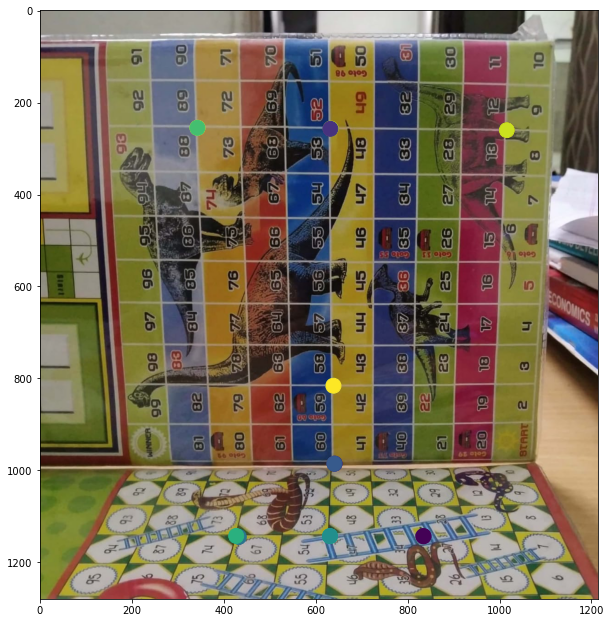

In [41]:
reproject(best_P,X)